# Titrating, planar surface in explicit salt

_Mikael Lund_

### System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `Python2`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 should work as well.

### Download and build Faunus

Wwe use a custom Metropolis Monte Carlo (MC) program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the complete faunus project and compile the program.

In [13]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/mikael/github/faunus-notebooks/surface-titrating


In [49]:
%%bash -s "$workdir"
cd $1
if [ ! -d "faunus/" ]; then
    echo 'fau_example(surf "./" surf.cpp)' > mc/CMakeLists.txt
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout 90811c4
else
    cd faunus
fi
pwd
CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=RelWithDebInfo -DENABLE_APPROXMATH=on -DMYPLAYGROUND=`pwd`/../mc &>/dev/null
make surf -j4

/Users/mikael/github/faunus-notebooks/surface-titrating/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
Scanning dependencies of target surf
[ 90%] Building CXX object /Users/mikael/github/faunus-notebooks/surface-titrating/mc/CMakeFiles/surf.dir/surf.cpp.o
[100%] Linking CXX executable surf
[100%] Built target surf


### Create Input and run MC simulation

In [56]:
def mkinput():
    global pH, micro
    js = {
        "processes": {
            "acid": { "pKd": 4.75, "pX": pH, "bound": "COOH", "free": "COO-" }
            },

         "energy": {
             "eqstate": { "processfile": "gctit.json" },
             "nonbonded": {
                "coulomb": { "epsr": 80 },
                "ljsimple": { "eps": 0.05 }
                }
            },

         "system": {
             "temperature": 298.15,
             "cuboid": { "len": 100 },
             "mcloop": { "macro": 10, "micro": micro }
            },

         "moves": {
             "gctit"         : { "molecule": "salt", "prob": 0.01 },
             "atomtranslate" : {
                 "lipid": { "prob": 1.0, "dp": 100, "dir":"1 1 0" },
                 "salt":  { "prob": 1.0, "dp": 100, "dir":"1 1 1" }
                }
            },

         "moleculelist": {
              "lipid": { "Ninit": 20, "atomic": True, "atoms": "COOH", "insdir": "1 1 0" },
              "salt":  { "Ninit": 20, "atomic": True, "atoms": "Na Cl" }
            },

          "atomlist": {
                "Na":   { "q": 1,  "r": 2, "dp": 50, "activity": salt },
                "Cl":   { "q": -1, "r": 2, "dp": 50, "activity": salt },
                "COOH": { "q": 0,  "r": 2, "dp": 20 },
                "COO-": { "q": -1, "r": 2, "dp": 20 }
                }
          }

    with open('surf.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

%cd $workdir'/mc'
micro=200000
for pH in [7.0]:
    for salt in [0.06]:
        for something in [1]:
            pfx='pH'+str(pH)+'-I'+str(salt)
            if True: #not os.path.isdir(pfx):
                %mkdir -p $pfx 
                %cd $pfx
                !rm -fR state
                mkinput()
                !../surf
                %cd ..

/Users/mikael/github/faunus-notebooks/surface-titrating/mc
/Users/mikael/github/faunus-notebooks/surface-titrating/mc/pH7.0-I0.06
# Reading process acid ... OK!
Reading space state file 'state'. State file not found.
# Reading process acid ... OK!

 .................
  Atom Properties  
 *****************
  Number of entries:       5
  Element info:
    unk   COO-  COOH  Cl    Na    

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cuboid
  Volume                   1e+06 Å³ = 1000 nm³ = 1e-21 liters
  Sidelengths              100 100 100 (Å)
  Scale directions         XYZ
  Number of particles      60
  Electroneutrality        Yes 0
  System sanity check      Passed
  Number of molecule types 2
  Groups:
    1     [0-19]           lipid       N/V = 2e-05  Å⁻³ = 33.2108 mM  
    2     [20-59]          salt        N/V = 4e-05  Å⁻³ = 66.4216 mM  

 ...............................................
  Energy: Nonb

### Read all Distribution Functions and Calculate Surface Excess

In [4]:
d = {}
rho=266
for salt in [0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 1e10]:
    d[salt] = {}
    for numpep in [2, 4, 8, 16, 32, 64, 128]:
        pfx='__rho'+str(rho)+'-N'+str(numpep)+'-I'+str(salt)
        
        distfile=pfx+'/cmdist.dat'
        if os.path.isfile(distfile): 
        
            r, P = np.loadtxt(distfile, unpack=True) # load data set
            w = -np.log(P) # potential of mean force (PMF)
        
            # normalize such that w(r)->0 for large r
            m = (r>200) & (r<220)
            if len(w[m])>0:
                w = w - w[m].mean()

                # remove tail
                w = w[r<200]
                r = r[r<200]
            
                # integrate PMF to surface excess
                gamma = np.trapz( np.expm1(-w), r  )
        
                d[salt][numpep] = [r, w, gamma]
    
    if len(d[salt])>0:
        d[salt] = pd.Series(d[salt])

data = pd.DataFrame(d)
data = data.rename(columns={1e10: r'$\infty$'})
data

/Users/mikael/miniconda/lib/python2.7/site-packages/pandas/core/index.py:1122: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,0.06,0.08,0.1,0.15,0.2,0.25,0.27,0.3,$\infty$
2,"[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,..."
4,"[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,..."
8,"[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14..."
16,"[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20..."
32,"[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21..."
64,NaN,NaN,"[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22.2, 22..."
128,NaN,"[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.0, 23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24...","[[23.0, 23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24..."


### MC: Fibril-surface interaction free energy
This will plot the PMF obtained from MC simulations at different fibril lenghts.

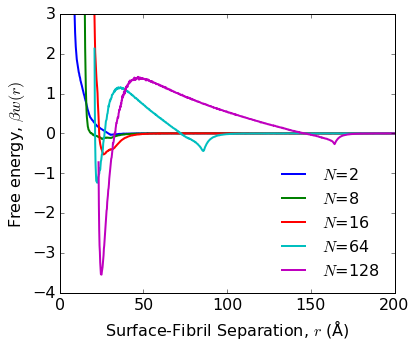

In [5]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

from scipy.signal import savgol_filter
for N, d in data[0.25].iteritems():
    if N in [2,8,16,64,128]:
        if type(d)!=type(float()):
            plt.plot(d[0], d[1], label='$N$='+str(N), lw=2)
            #plt.plot(d[0], savgol_filter(d[1], 9, 2), lw=2)

plt.legend(loc=0, frameon=False, fontsize='medium')
plt.xlabel('Surface-Fibril Separation, $r$ (Å)')
plt.ylabel(r'Free energy, $\beta w(r)$')
plt.ylim((-4,3))
plt.savefig('mc_pmf.pdf', bbox_inches='tight')

### MC: Surface excess at different salt concentrations and fibril lengths

/Users/mikael/miniconda/lib/python2.7/site-packages/pandas/core/index.py:1759: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


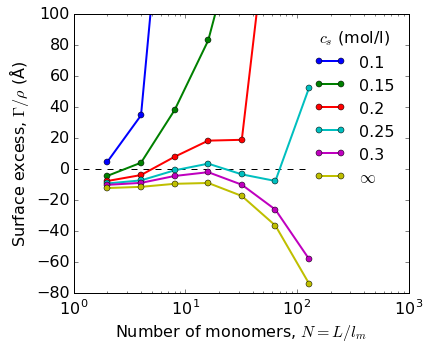

In [6]:
def f(x):
    if type(x)!=type(float()):
        return x[2]
    else:
        return x

plt.plot( [0,128], [0,0], 'k--')

for salt, d in data.iteritems():
    if salt>=0.1 and salt!=0.27:
        _d = d.apply(f)
        plt.plot(_d.keys(), _d.get_values(), label=salt, linestyle='-', marker='o', lw=2, ms=6)

plt.legend(loc=0,frameon=False, fontsize='medium', title=r'$c_{s}$ (mol/l)')
plt.xlabel(r'Number of monomers, $N=L/l_m$')
plt.ylabel(r'Surface excess, $\Gamma/\rho$ (Å)')
plt.xscale('log')
plt.ylim((-80,100))
plt.xlim(1, 1000)
plt.savefig('mc_excess.pdf', bbox_inches='tight')